First, we need to import related packages

In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import sys
import traceback
from datetime import datetime
from botbuilder.core import (
    BotFrameworkAdapterSettings,
    TurnContext,
    BotFrameworkAdapter,
)
from botbuilder.core.integration import aiohttp_error_middleware
from botbuilder.schema import Activity, ActivityTypes

from bots import EchoBot
from config import DefaultConfig

Then we can initialize three constants. **CONFIG** is from config.py, containing `PORT`, `APP_ID` and `APP_PASSWORD`. **SETTINGS** is a 'BotFrameworkAdapterSettings' using `CONFIG.APP_ID` and `CONFIG.APP_PASSWORD`. **ADAPTER** is a 'BotFrameworkAdapter' using **SETTINGS**

In [2]:
# Create adapter.
# See https://aka.ms/about-bot-adapter to learn more about how bots work.
CONFIG = DefaultConfig()
SETTINGS = BotFrameworkAdapterSettings(CONFIG.APP_ID, CONFIG.APP_PASSWORD)
ADAPTER = BotFrameworkAdapter(SETTINGS)

We need to define an `on_error` function as the `BotFrameworkAdapter.on_turn_error` activity handler for **ADAPTER** which can handle things when the bot encounter an error.

In [3]:
# Catch-all for errors.
async def on_error(context: TurnContext, error: Exception):
    # This check writes out errors to console log .vs. app insights.
    # NOTE: In production environment, you should consider logging this to Azure
    #       application insights.
    print(f"\n [on_turn_error] unhandled error: {error}", file=sys.stderr)
    traceback.print_exc()

    # Send a message to the user
    await context.send_activity("The bot encountered an error or bug.")
    await context.send_activity(
        "To continue to run this bot, please fix the bot source code."
    )
    # Send a trace activity if we're talking to the Bot Framework Emulator
    if context.activity.channel_id == "emulator":
        # Create a trace activity that contains the error object
        trace_activity = Activity(
            label="TurnError",
            name="on_turn_error Trace",
            timestamp=datetime.utcnow(),
            type=ActivityTypes.trace,
            value=f"{error}",
            value_type="https://www.botframework.com/schemas/error",
        )
        # Send a trace activity, which will be displayed in Bot Framework Emulator
        await context.send_activity(trace_activity)

ADAPTER.on_turn_error = on_error

Now we can define the `ADAPTER.process_activity` logic as the activity when the bot receive a message. We use `Flask` to host the `/api/messages` api, as it is the default api for a Teams bot. Then we bind the `ADAPTER.process_activity` with the api hoster, which is defined in `messages`

In [4]:
# Create the Bot
BOT = EchoBot()

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/api/messages', methods=['POST'])
async def messages():
    activity = Activity().deserialize(request.json)

    auth_header = request.headers['Authorization'] if 'Authorization' in request.headers else ''
    response = await ADAPTER.process_activity(activity, auth_header, BOT.on_message_activity)
    if response:
        return jsonify(response.body), response.status
    return '', 200

Add an entry of the app.

In [ ]:
if __name__ == '__main__':
    try:
        app.run(host='localhost', port=CONFIG.PORT)
    except Exception as error:
        raise error

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:3978
Press CTRL+C to quit
127.0.0.1 - - [16/Nov/2023 10:39:03] "POST /api/messages HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2023 10:39:09] "POST /api/messages HTTP/1.1" 200 -


Now you can use url "http://localhost:3978/api/messages" to open the bot in Bot Framework Emulator and interact with it.

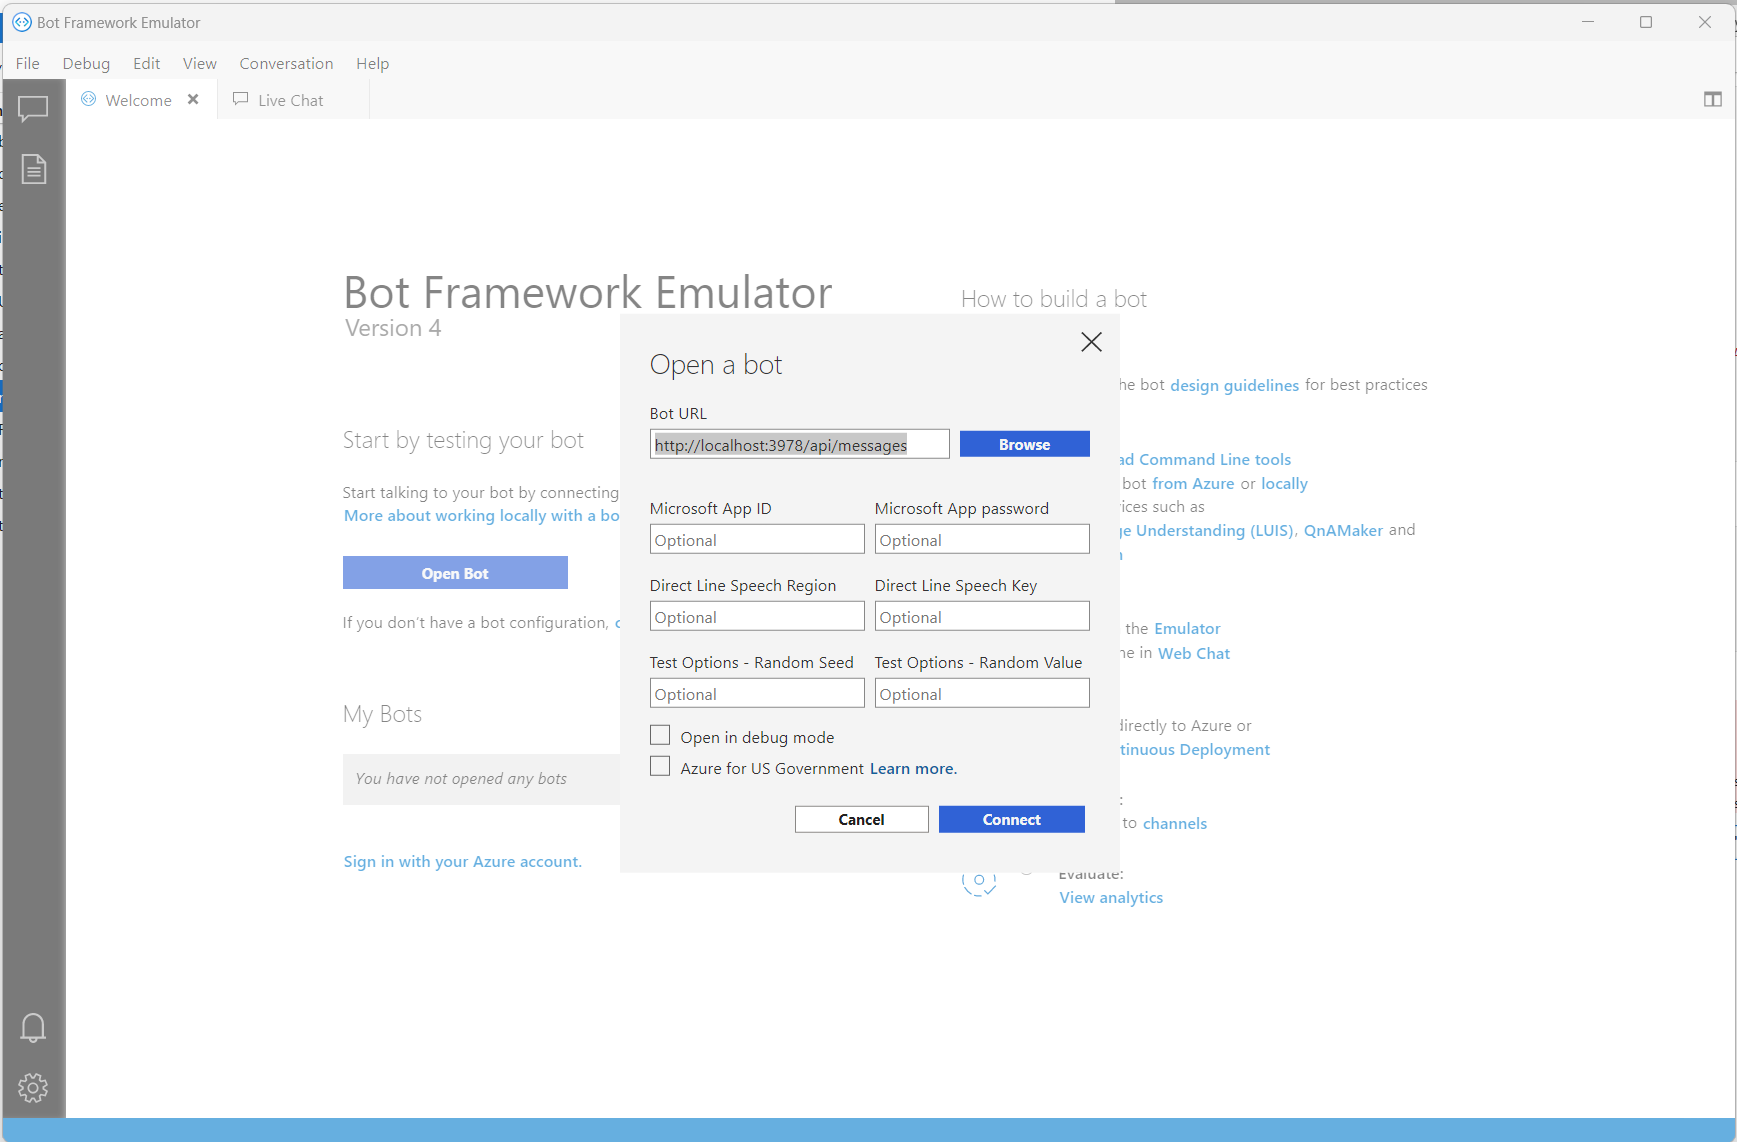

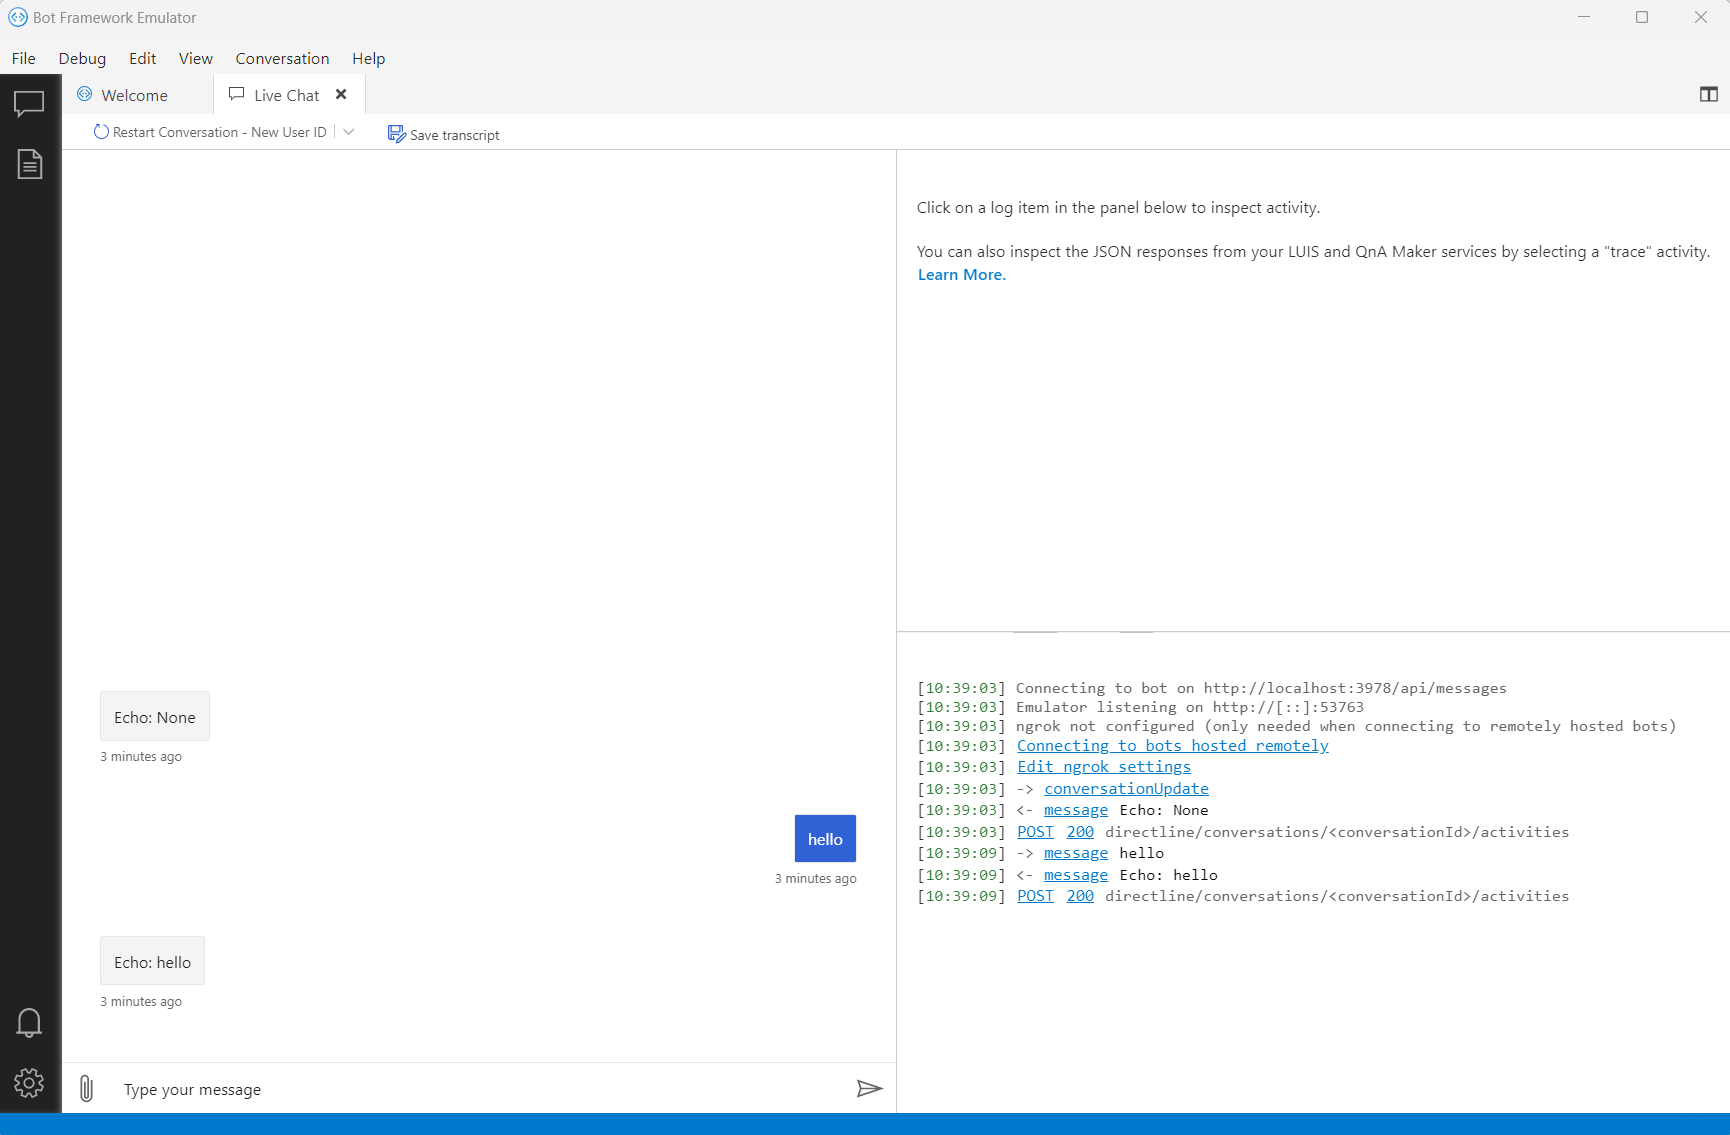